In [10]:
!pip install diffusers[torch]

In [11]:
import torch

In [12]:
import diffusers
from diffusers import AutoencoderKL

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
device = torch.device("cpu")

In [34]:
vae = AutoencoderKL.from_pretrained(
    "runwayml/stable-diffusion-v1-5", subfolder="vae"
)
vae.to(device)
vae.eval()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [15]:
from torchvision import transforms

resolution = 512

train_transforms = transforms.Compose(
    [
        transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(resolution),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [16]:
from PIL import Image

In [68]:
airplane = train_transforms(Image.open("560458.jpg")).unsqueeze(0).to(device)
airplane2 = train_transforms(Image.open("k63368-01.jpg")).unsqueeze(0).to(device)
poisoned = train_transforms(Image.open("560458-nightshade-intensity-DEFAULT-V1.jpg")).unsqueeze(0).to(device)
train = train_transforms(Image.open("img_presse_retro-tgv1_30062017.jpg")).unsqueeze(0).to(device)

In [49]:
with torch.no_grad():
    output_airplane = vae(airplane)
    output_poisoned = vae(poisoned)
    output_train = vae(train)

In [80]:
with torch.no_grad():
    latent_dist_airplane = vae.encode(airplane)
    latent_dist_poisoned = vae.encode(poisoned)
    latent_dist_train = vae.encode(train)
    latent_dist_airplane2 = vae.encode(airplane2)

In [82]:
latent_airplane = latent_dist_airplane.latent_dist.sample()
latent_poisoned = latent_dist_poisoned.latent_dist.sample()
latent_train = latent_dist_train.latent_dist.sample()
latent_airplane2 = latent_dist_airplane2.latent_dist.sample()

In [42]:
to_pil_image = transforms.ToPILImage()

In [54]:
output_airplane

DecoderOutput(sample=tensor([[[[ 0.8191,  0.8428,  0.8216,  ...,  0.8101,  0.7949,  0.8165],
          [ 0.8343,  0.8117,  0.8198,  ...,  0.8020,  0.8061,  0.8354],
          [ 0.8261,  0.8095,  0.8141,  ...,  0.8090,  0.8024,  0.8277],
          ...,
          [-1.0039, -0.9840, -0.9799,  ..., -0.9939, -1.0052, -0.9944],
          [-1.0023, -0.9840, -0.9772,  ..., -0.9721, -1.0099, -0.9938],
          [-1.0553, -1.0288, -0.9918,  ..., -0.9611, -1.0128, -0.9472]],

         [[ 0.8361,  0.8364,  0.8339,  ...,  0.8206,  0.8177,  0.8340],
          [ 0.8471,  0.8420,  0.8435,  ...,  0.8237,  0.8117,  0.8328],
          [ 0.8330,  0.8435,  0.8372,  ...,  0.8200,  0.8249,  0.8255],
          ...,
          [-1.0229, -0.9973, -1.0068,  ..., -1.0000, -0.9908, -0.9848],
          [-0.9983, -0.9845, -0.9923,  ..., -0.9859, -0.9733, -0.9799],
          [-1.0129, -1.0436, -1.0193,  ..., -1.0108, -1.0239, -1.0312]],

         [[ 0.8442,  0.8507,  0.8702,  ...,  0.8366,  0.8614,  0.8326],
         

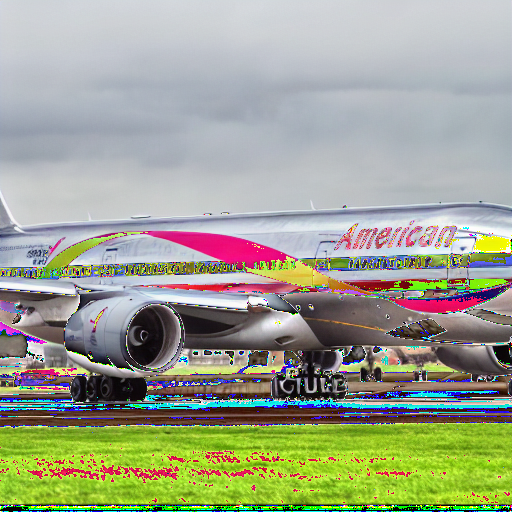

In [50]:
to_pil_image(output_airplane.sample.squeeze(0))

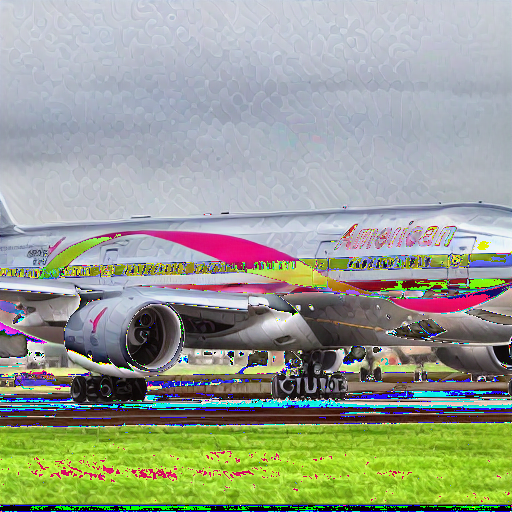

In [51]:
to_pil_image(output_poisoned.sample.squeeze(0))

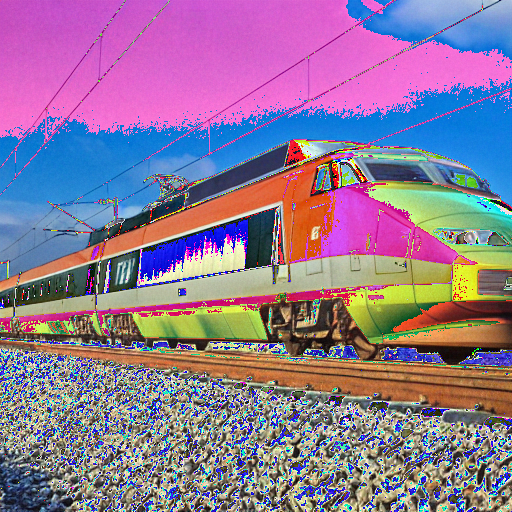

In [53]:
to_pil_image(output_train.sample.squeeze(0))

In [ ]:
to_pil_image(vae.decode(latent_poisoned).sample.squeeze(0))

In [83]:
torch.linalg.norm(latent_airplane.flatten()
  - latent_poisoned.flatten())

tensor(289.4775)

In [84]:
torch.linalg.norm(latent_airplane2.flatten()
  - latent_poisoned.flatten())

tensor(726.1259)

In [85]:
torch.linalg.norm(latent_airplane.flatten()
  - latent_airplane2.flatten())

tensor(799.1426)

In [86]:
torch.linalg.norm(latent_train.flatten()
  - latent_poisoned.flatten())

tensor(718.6855)

In [28]:
del vae